# Model training notebook

## 1. Initial Random Forest models

### Loading necessary libraries

In [21]:
# %% [code]
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set up your database connection string using environment variables.
# Make sure to set DB_USER, DB_PASS, DB_HOST, and DB_NAME in your environment.
db_user = os.environ.get("DB_USER")
db_pass = os.environ.get("DB_PASS")
db_host = os.environ.get("DB_HOST")
db_name = os.environ.get("DB_NAME")
connection_string = f'mysql+pymysql://{db_user}:{db_pass}@{db_host}/{db_name}'
engine = create_engine(connection_string)



### Connecting to MYSQL DB

In [22]:
# Load the processed features table (assumed to be called "features_blocks")
features_blocks = pd.read_sql_table("features_blocks", engine)
print(f"Loaded {len(features_blocks)} rows from features_blocks.")


athlete_id = 64383208  # e.g., '12345'


Loaded 6 rows from features_blocks.


### EDA on the features_blocks table

In [23]:
features_blocks

,f_slope_run_distance_before_taper,f_taper_factor_run_distance,f_slope_run_time_before_taper,f_taper_factor_run_time,f_slope_mean_hr_before_taper,f_taper_factor_mean_hr,f_avg_weekly_run_distance,r_avg_weekly_run_distance,f_avg_weekly_non_run_distance,r_avg_weekly_non_run_distance,...,f_proportion_intense_activities,proportion_intense_activities,r_proportion_intense_activities,f_proportion_varying_activities,proportion_varying_activities,r_proportion_varying_activities,athlete_id,block_id,y_vdot_delta,y_vdot
0,NaN,2.624574,NaN,2.690349,NaN,1.013470,9337.760000,0.717724,107.444444,0.091693,...,0.09,0.07,1.29,0.04,0.11,0.36,64383208,9027092441,0.000000,32.408370
1,NaN,1.938752,NaN,1.854459,NaN,0.989575,9805.212500,0.753653,0.000000,0.000000,...,0.08,0.07,1.14,0.05,0.11,0.45,64383208,10511883506,0.000000,24.428489
2,NaN,1.943283,NaN,1.904053,NaN,0.994776,14693.187500,1.129356,2412.750000,2.059045,...,0.13,0.07,1.86,0.10,0.11,0.91,64383208,11337864648,5.227752,29.656240
3,NaN,0.894377,NaN,0.951501,NaN,0.942267,23048.870000,1.771594,2626.037500,2.241064,...,0.02,0.07,0.29,0.23,0.11,2.09,64383208,11718704719,1.262159,33.670529
4,1468.916970,0.983954,636.921212,0.879105,-0.288939,1.020899,18726.175000,1.439341,3498.333333,2.985483,...,0.06,0.07,0.86,0.33,0.11,3.00,64383208,12413500570,2.451583,36.122112
5,1365.458182,1.156694,453.248485,1.034040,0.476566,1.023460,19445.508333,1.494631,3148.500000,2.686935,...,0.04,0.07,0.57,0.30,0.11,2.73,64383208,12525935628,0.873017,30.529257


Dataset shape: (6, 74)
   f_slope_run_distance_before_taper  f_taper_factor_run_distance  \
0                                NaN                     2.624574   
1                                NaN                     1.938752   
2                                NaN                     1.943283   
3                                NaN                     0.894377   
4                         1468.91697                     0.983954   

   f_slope_run_time_before_taper  f_taper_factor_run_time  \
0                            NaN                 2.690349   
1                            NaN                 1.854459   
2                            NaN                 1.904053   
3                            NaN                 0.951501   
4                     636.921212                 0.879105   

   f_slope_mean_hr_before_taper  f_taper_factor_mean_hr  \
0                           NaN                1.013470   
1                           NaN                0.989575   
2                 

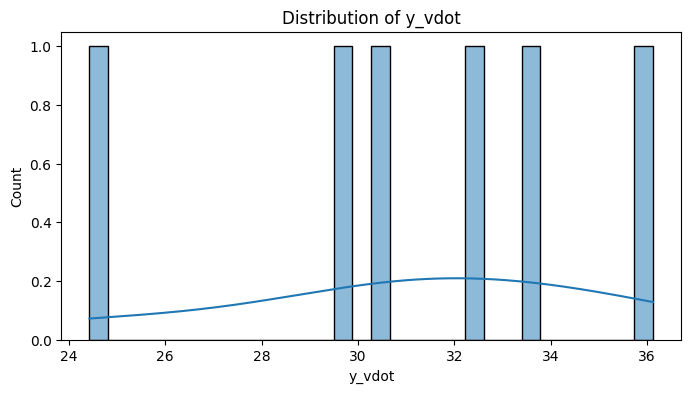

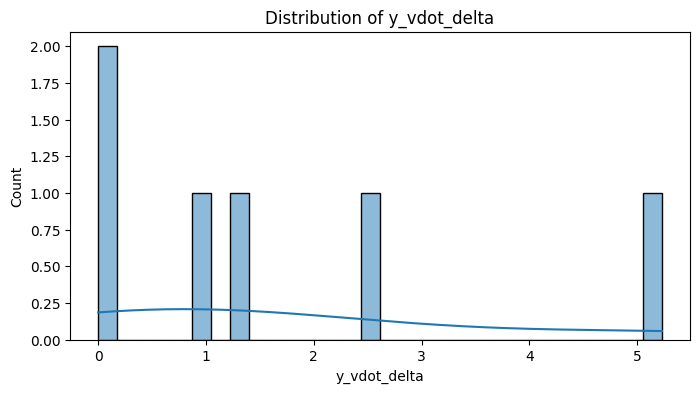

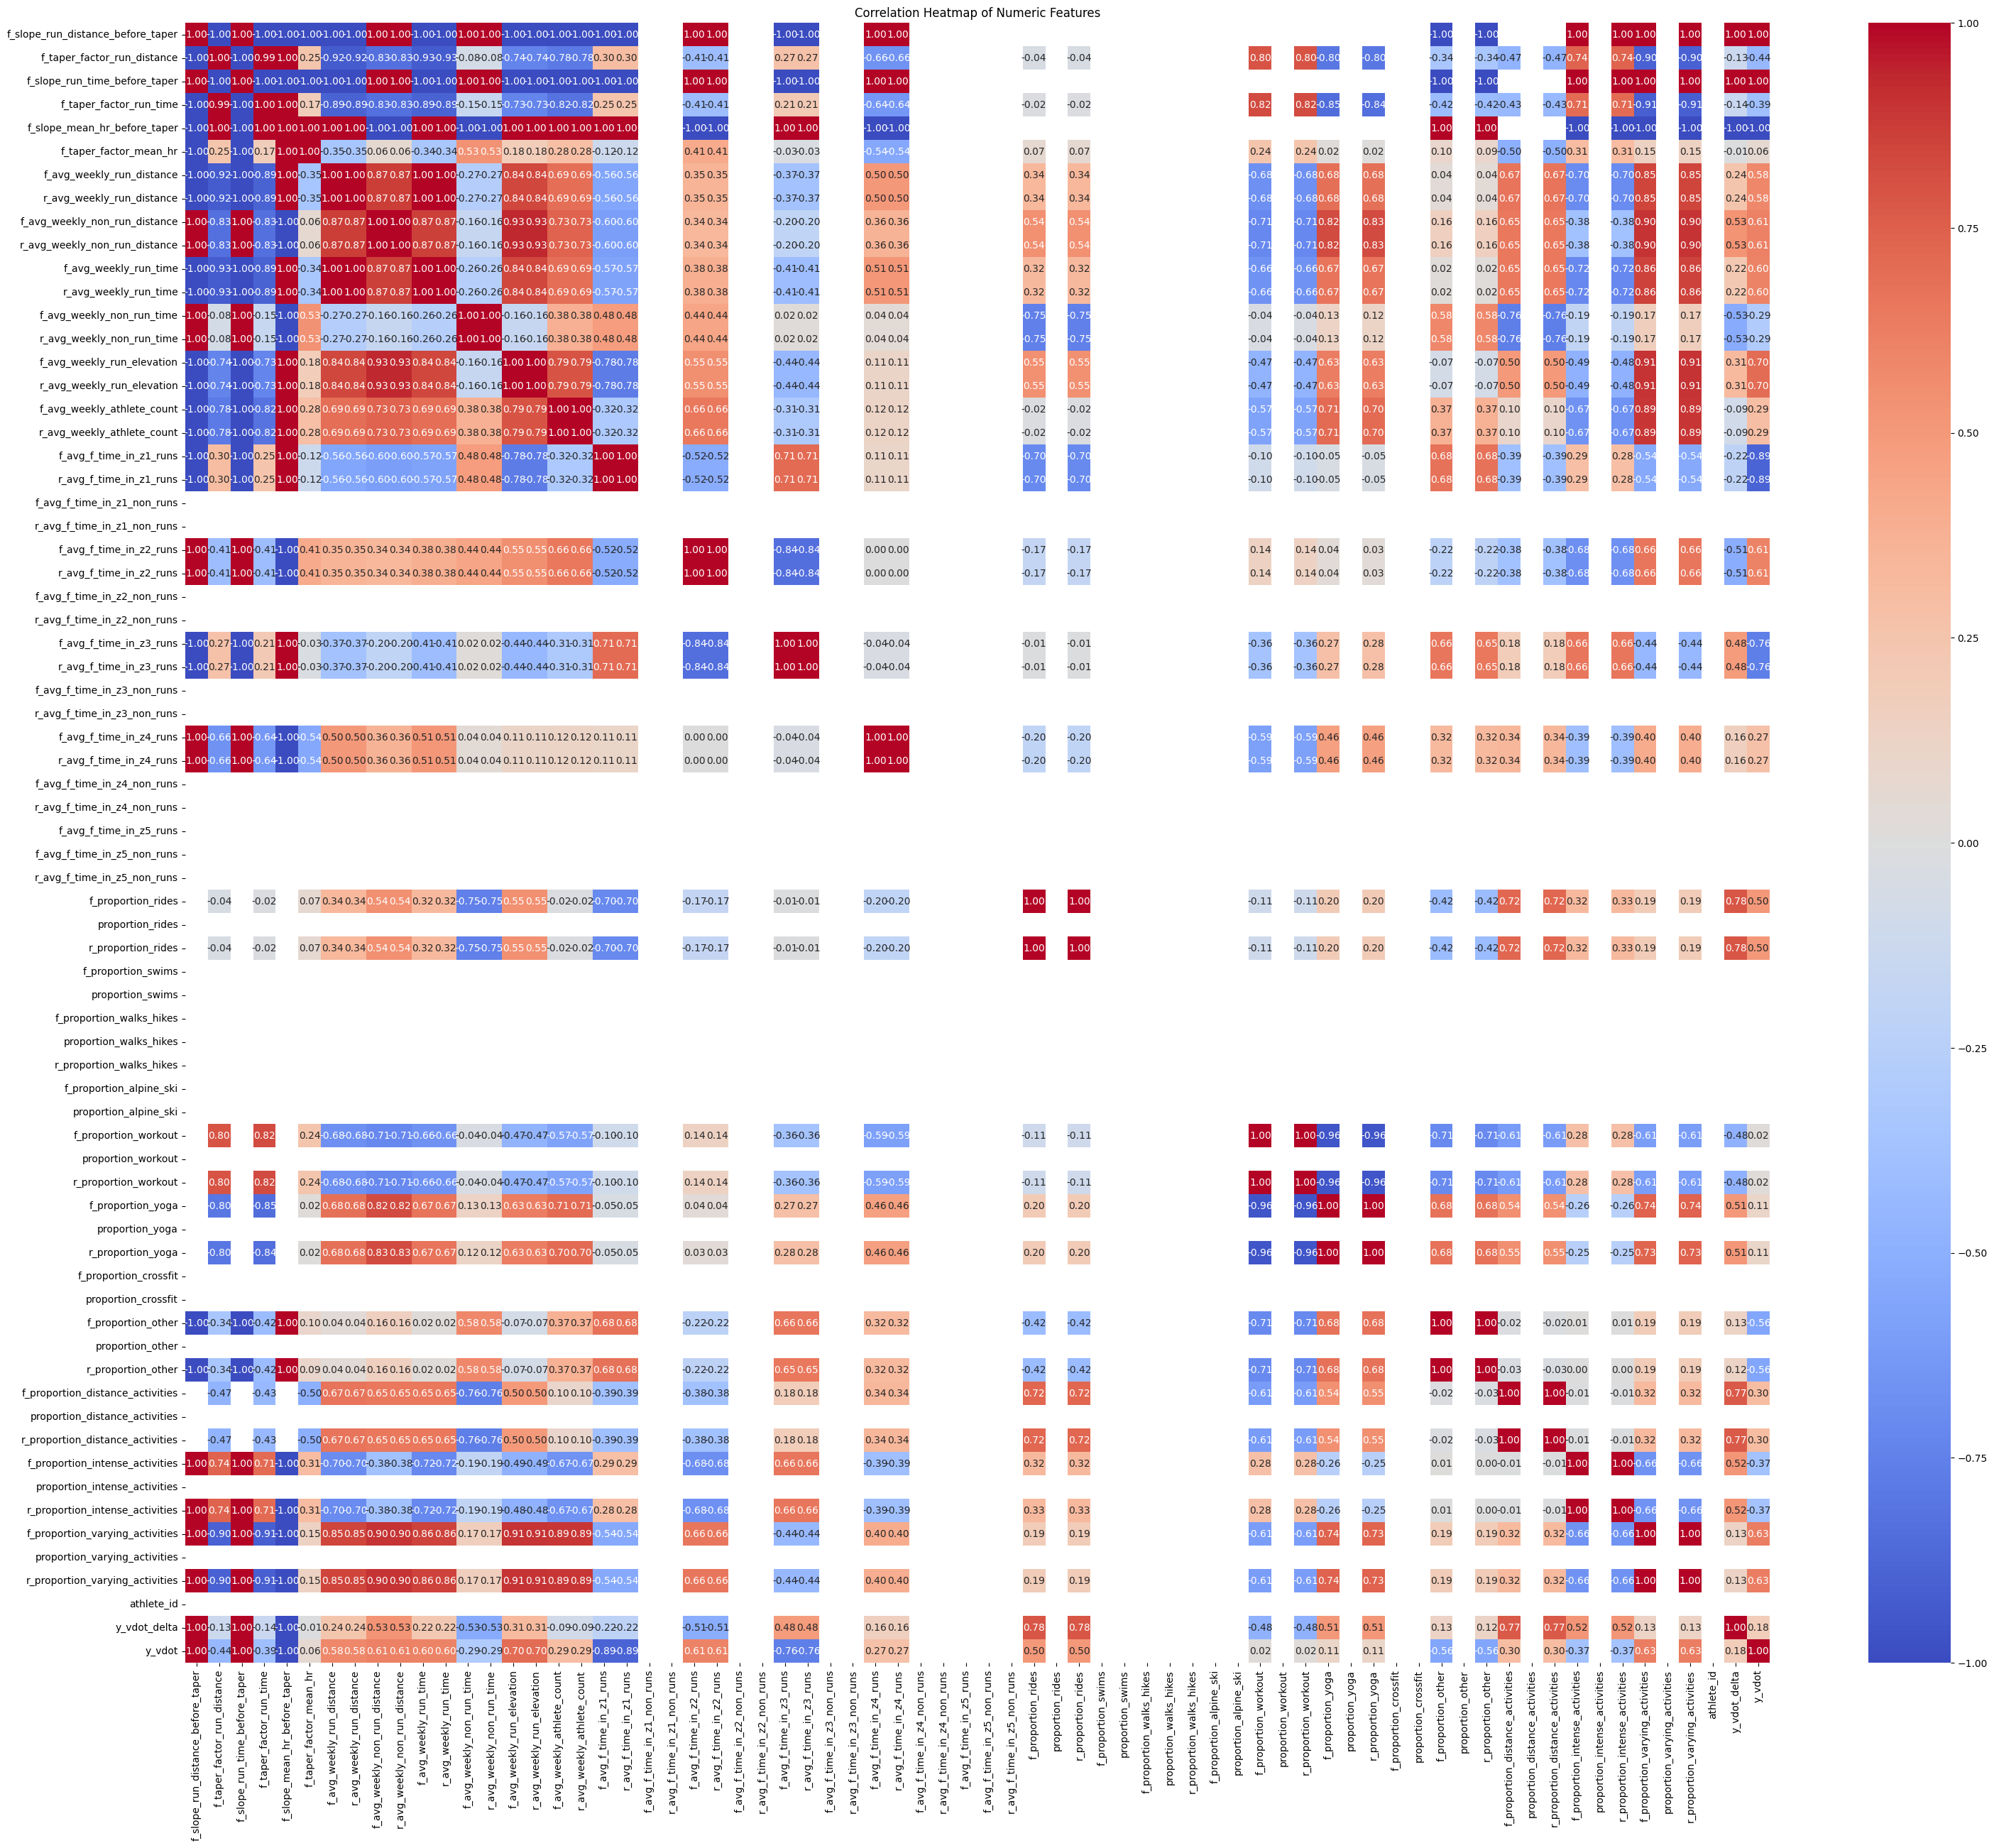

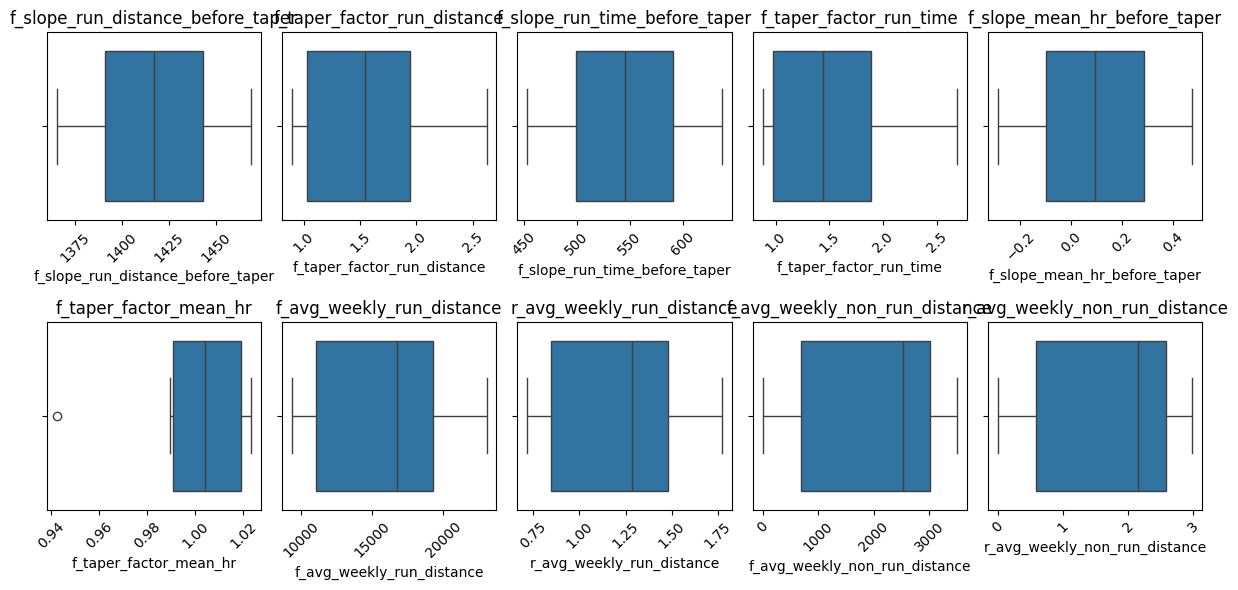

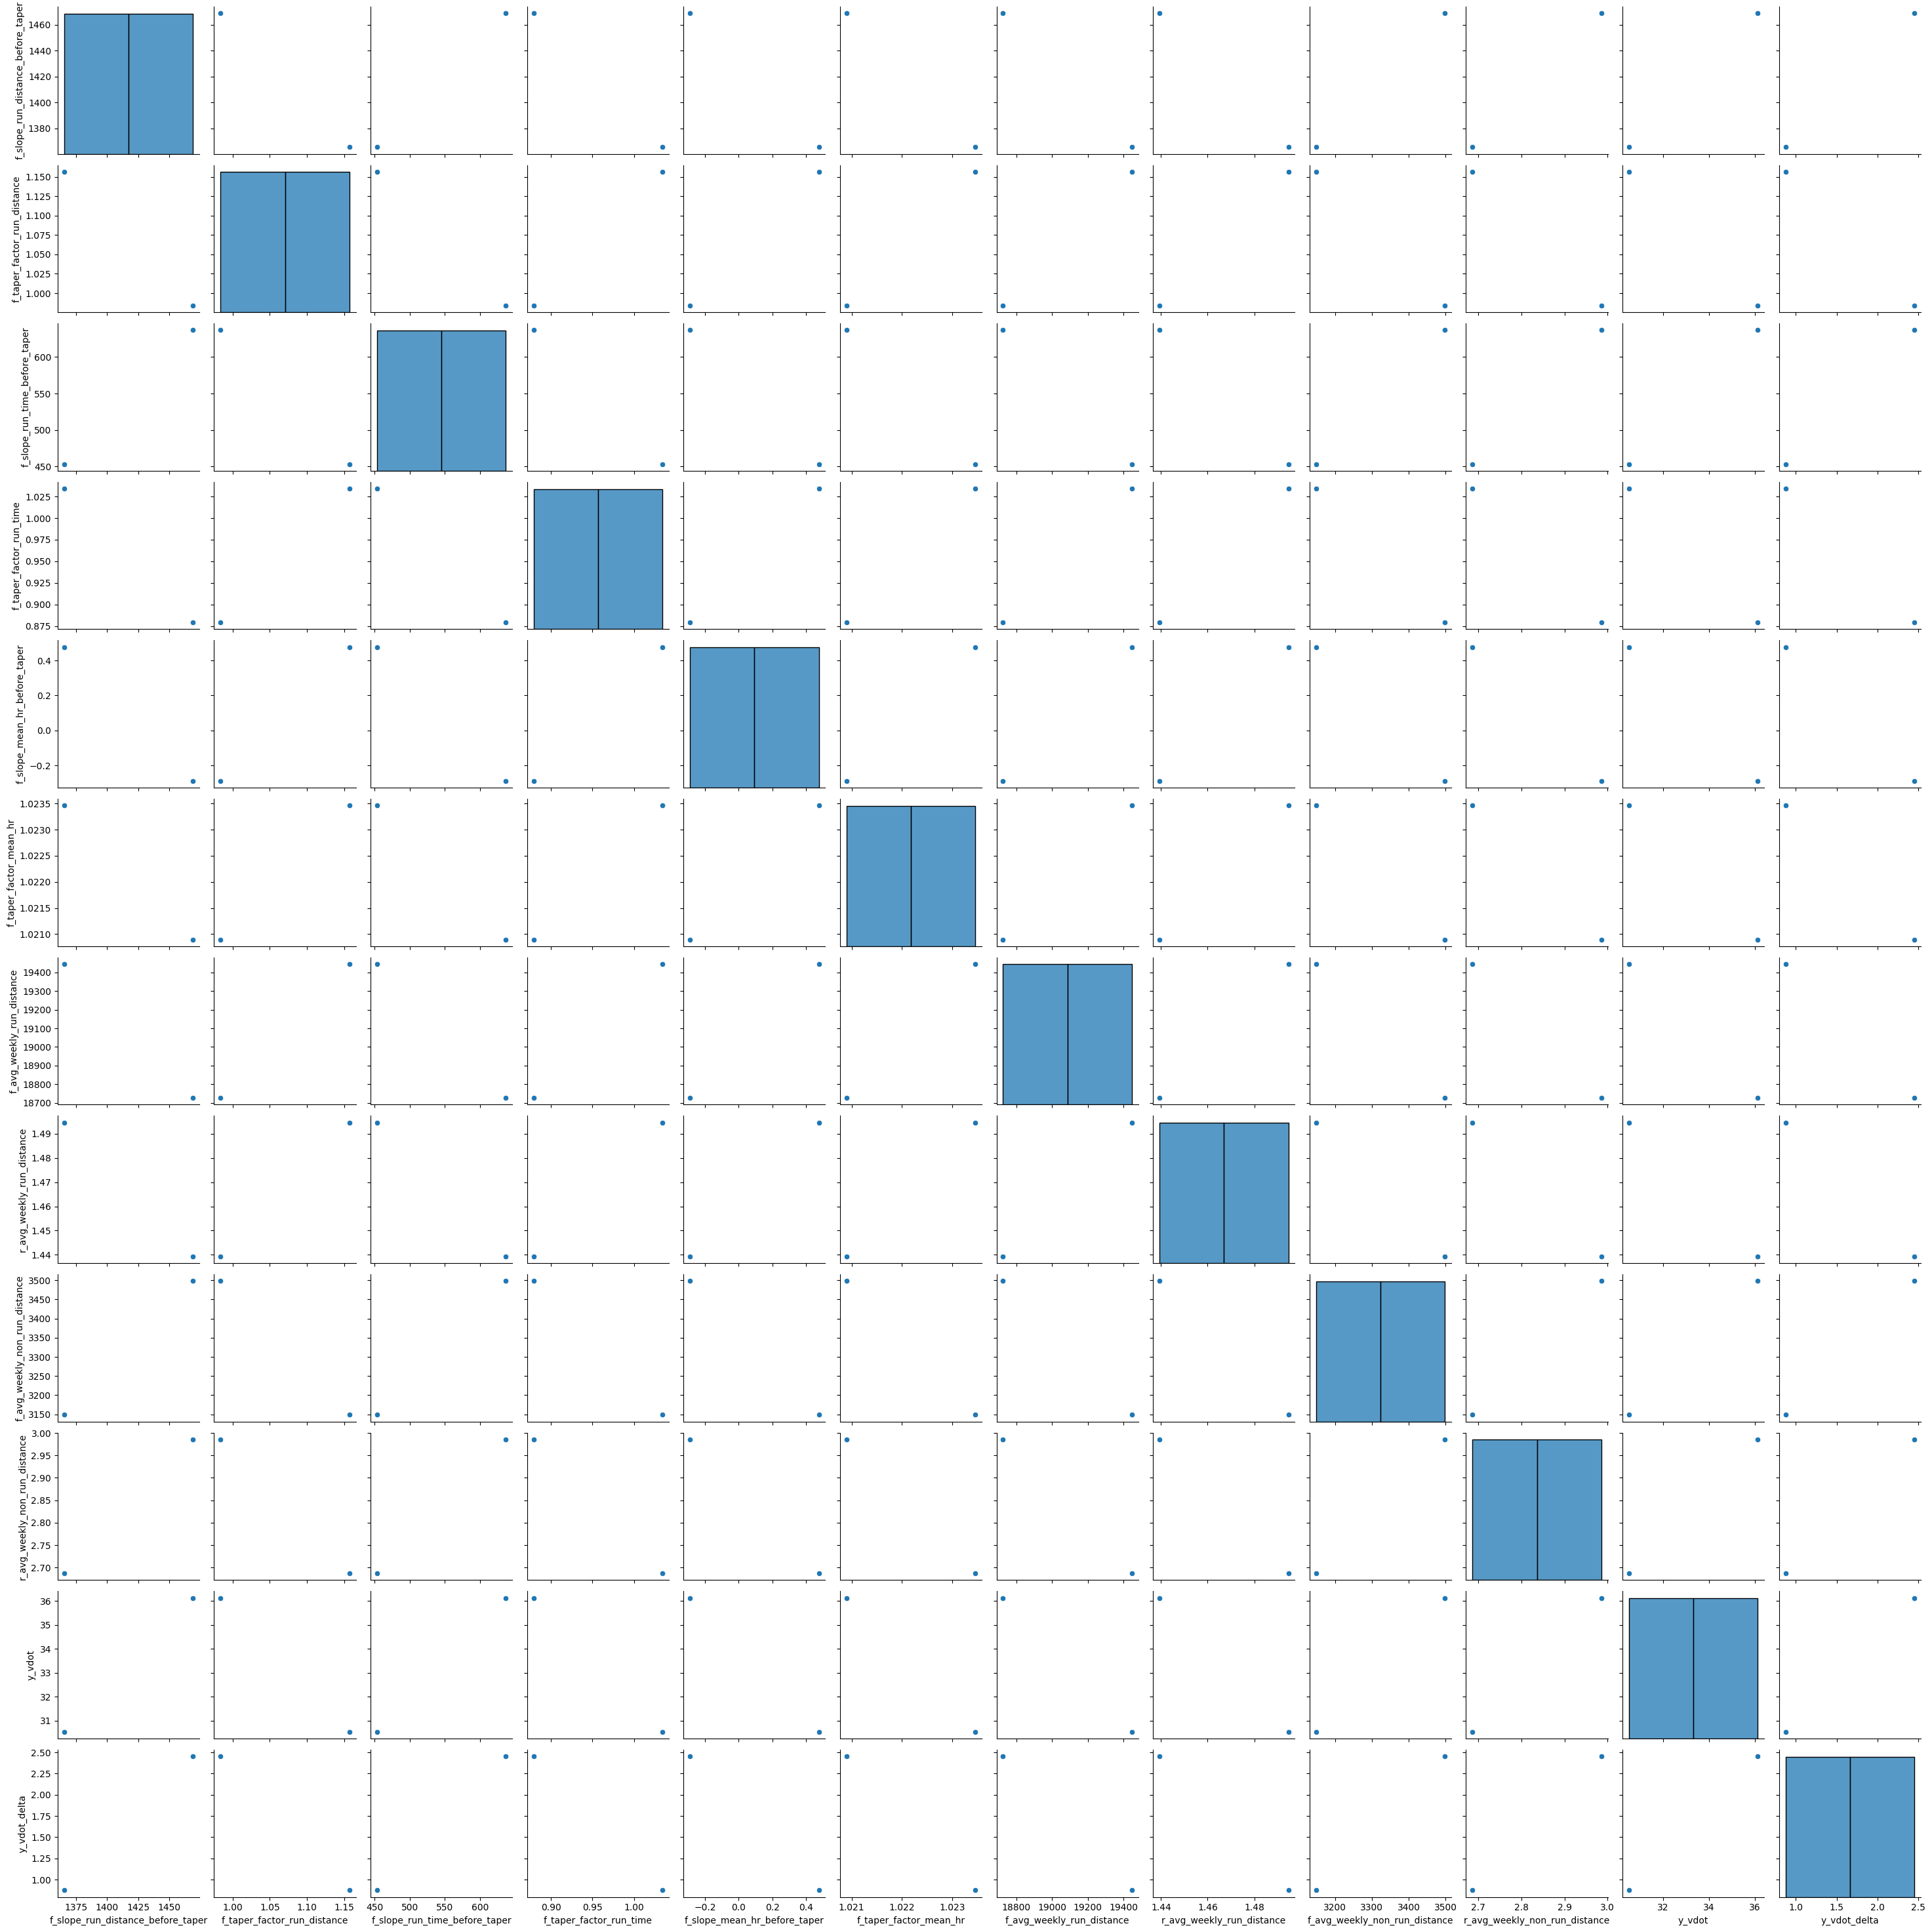

In [26]:
# Load the processed features table
df = features_blocks
print("Dataset shape:", df.shape)
print(df.head())

# %% [code]
# Descriptive statistics
desc = df.describe()
print("Descriptive Statistics:")
print(desc)

# %% [code]
# Check for missing values
missing = df.isnull().sum()
print("Missing values by column:")
print(missing)

# %% [code]
# Plot distributions of target variables
target_cols = ['y_vdot', 'y_vdot_delta']  # adjust column names if needed
for col in target_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# %% [code]
# Correlation matrix for numeric features
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(36, 30))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# %% [code]
# Box plots for a few key features to check for outliers
key_features = list(numeric_df.columns)[:10]  # adjust if you want specific columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(key_features):
    plt.subplot(2, 5, i+1)
    sns.boxplot(x=numeric_df[col])
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %% [code]
# Pairplot of a few selected features and targets
selected_cols = key_features + target_cols
sns.pairplot(df[selected_cols].dropna())
plt.show()


In [27]:
columns_with_nan = df.columns[df.isna().any()].tolist()

print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['f_slope_run_distance_before_taper', 'f_slope_run_time_before_taper', 'f_slope_mean_hr_before_taper', 'f_avg_f_time_in_z1_non_runs', 'r_avg_f_time_in_z1_non_runs', 'f_avg_f_time_in_z2_non_runs', 'r_avg_f_time_in_z2_non_runs', 'f_avg_f_time_in_z3_non_runs', 'r_avg_f_time_in_z3_non_runs', 'f_avg_f_time_in_z4_non_runs', 'r_avg_f_time_in_z4_non_runs', 'f_avg_f_time_in_z5_non_runs', 'r_avg_f_time_in_z5_non_runs', 'r_proportion_swims', 'r_proportion_alpine_ski', 'r_proportion_crossfit']


Columns with NaN values : 
- f_slope_run_distance_before_taper
- f_slope_run_time_before_taper
- f_slope_mean_hr_before_taper
- f_avg_f_time_in_z1_non_runs
- r_avg_f_time_in_z1_non_runs
- f_avg_f_time_in_z2_non_runs
- r_avg_f_time_in_z2_non_runs
- f_avg_f_time_in_z3_non_runs
- r_avg_f_time_in_z3_non_runs
- f_avg_f_time_in_z4_non_runs
- r_avg_f_time_in_z4_non_runs
- f_avg_f_time_in_z5_non_runs
- r_avg_f_time_in_z5_non_runs
- r_proportion_swims
- r_proportion_alpine_ski
- r_proportion_crossfit

Donc : 
- Pour les slope, c'est dans calculate_training_metrics dans athlete_data_transformer, c'est une reg lin du coup voir pq ça donne des NaN values
- Les zones pour les activités autres que la course, solution => probablement utiliser le mean hr => du coup ce sera one hot encoding pour les zones mais ok pour l'instant ?
- Regarder aussi les zones pour les runs avec pas de données hr !!
- pour les proportions autres activiés, c'est full 0 mais ça donne des erreurs quand je normalise ? à voir

=> Faire un notebook pour le processing aussi ? 

=> Faire des docs pour chaque table : comprendre d'ou vient la donnée, quelle ligne de code la génère, et ce que la donnée veut dire

=> Faire en sorte qu'il y ait plus aucune valeur NaN dans chaque table

Filtered to 6 rows for athlete 64383208.
Absolute VDOT model R² score: 0.0
VDOT Change model R² score: -0.6854227767769272


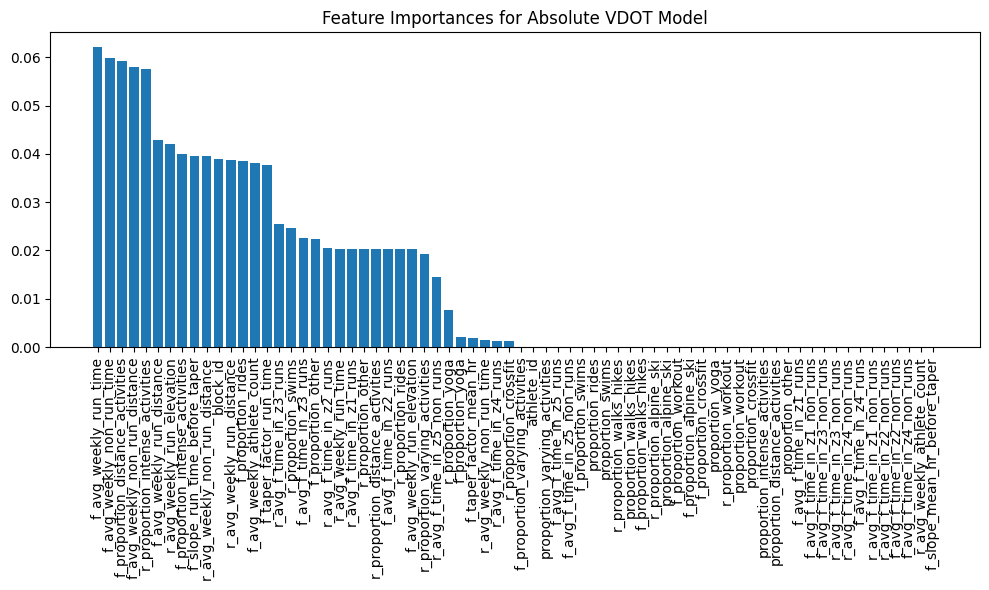

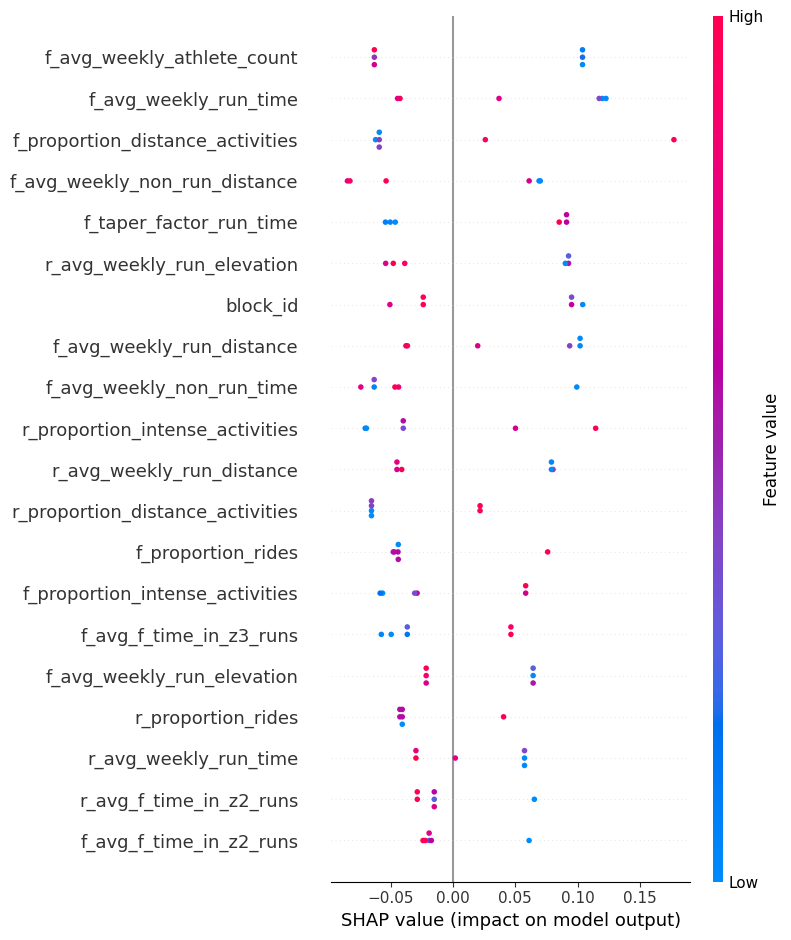

In [17]:
if athlete_id is not None:
    features_blocks = features_blocks[features_blocks['athlete_id'] == athlete_id]
    print(f"Filtered to {len(features_blocks)} rows for athlete {athlete_id}.")

if features_blocks.empty:
    print("No features data found. Please check your processed data table.")
else:
    # Assume that the feature columns are between the first two columns and the last two target columns.
    # Adjust slicing if your schema is different.
    feature_cols = features_blocks.columns[2:-2]
    
    # Prepare the feature matrix X and targets y.
    X = features_blocks[feature_cols].apply(pd.to_numeric, errors='coerce')
    # Fill missing values with the column mean (or you can choose another strategy)
    X = X.fillna(X.mean())
    X = X.to_numpy()
    
    # Targets: assume the last two columns are y_vdot (absolute VDOT) and y_vdot_delta (change)
    y_absolute = pd.to_numeric(features_blocks.iloc[:, -2], errors='coerce').fillna(0).to_numpy()
    y_change   = pd.to_numeric(features_blocks.iloc[:, -1], errors='coerce').fillna(0).to_numpy()
    
    # Train-test split for the absolute VDOT model
    X_train, X_test, y_train, y_test = train_test_split(X, y_absolute, test_size=0.2, random_state=42)
    rf_abs = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_abs.fit(X_train, y_train)
    y_pred_abs = rf_abs.predict(X_test)
    score_abs = r2_score(y_test, y_pred_abs)
    print("Absolute VDOT model R² score:", score_abs)
    
    # Train-test split for the VDOT change model
    X_train, X_test, y_train, y_test = train_test_split(X, y_change, test_size=0.2, random_state=42)
    rf_change = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_change.fit(X_train, y_train)
    y_pred_change = rf_change.predict(X_test)
    score_change = r2_score(y_test, y_pred_change)
    print("VDOT Change model R² score:", score_change)
    
    # Plot feature importances for the Absolute VDOT model
    importances = rf_abs.feature_importances_
    # Sort feature indices by importance
    sorted_indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances for Absolute VDOT Model")
    plt.bar(range(len(importances)), importances[sorted_indices], align="center")
    plt.xticks(range(len(importances)), feature_cols[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Optionally, if you have SHAP installed, generate a summary plot
    try:
        import shap
        explainer = shap.TreeExplainer(rf_abs)
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, feature_names=list(feature_cols), show=True)
    except ImportError:
        print("SHAP is not installed. Skipping SHAP plots.")